In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from Shadow.ShadowPreprocessorsXraylib import prerefl, pre_mlayer, bragg
from pykern import pkjson
from pykern import pkio
from pykern.pkcollections import PKDict
from pykern.pkdebug import pkdc, pkdp
from sirepo.template import transfer_mat_bl
from srxraylib.sources import srfunc
import Shadow
import math
import numpy
import re
import scipy.linalg as sla

from orangecontrib.shadow.util.undulator.source_undulator import SourceUndulator
from syned.storage_ring.electron_beam import ElectronBeam
from syned.storage_ring.magnetic_structures.undulator import Undulator

In [2]:
# from https://github.com/radiasoft/rslight/blob/main/Gaussian/gauss_apert-01.py

#  Propagate a 4x4 covariance matrix Sigma through a Gaussian aperture of (Gaussian, not not hard-edge)
#  size parameters a_gx, a_gy
#  NB:  assumed ordering of the variables is x, y, theta_x, theta_y
def gauss_apert_4x4(Sigma, lambda_rad, a_gx, a_gy):
    Sigma_inv = sla.inv(Sigma)
    A = 1.0 *Sigma_inv[0:2,0:2]
    B = 1.0 *Sigma_inv[0:2,2:4]
    C = numpy.transpose(B)
    D = 1.0 *Sigma_inv[2:4,2:4]

    A_A = numpy.zeros([2,2], dtype=numpy.float32)
    A_A[0,0] = 2. /a_gx**2
    A_A[1,1] = 2. /a_gy**2

    D_inv = sla.inv(D)
    D_A_inv = numpy.zeros([2,2], dtype=numpy.float32)
    D_A_inv[0,0] = 1. /a_gx**2
    D_A_inv[1,1] = 1. /a_gy**2
    D_A_inv *= lambda_rad**2 /(8. *numpy.pi *numpy.pi)

    D_f = sla.inv(D_inv +D_A_inv)
    BDi = numpy.matmul(B, D_inv)
    DiC = numpy.matmul(D_inv, C)  #  == numpy.transpose(BDi)
    C_f = numpy.matmul(D_f, DiC)
    B_f = numpy.transpose(C_f)    #  ==  numpy.matmul(BDi, D_f)
    A_f = A +A_A -numpy.matmul(BDi, C) +numpy.matmul(BDi, numpy.matmul(D_f, DiC))

    Sigma_inv[0:2,0:2] = 1.0 *A_f
    Sigma_inv[0:2,2:4] = 1.0 *B_f
    Sigma_inv[2:4,0:2] = 1.0 *C_f
    Sigma_inv[2:4,2:4] = 1.0 *D_f

    return sla.inv(Sigma_inv)

In [3]:
# need to prime seed prior to calculate_rays SEED to get reproducible results
numpy.random.seed(1)

ebeam = ElectronBeam(
    energy_in_GeV=3.0,
    energy_spread=0.00089,
    current=0.5,
    number_of_bunches=1,
)
ebeam.set_twiss_all(
  9e-10, # emitx
  0.0, # alphax
  2.02, # betax
  0.0, # etax
  0.0, # etapx
  8e-12, # emity
  0.0, # alphay
  1.06, # betay
  0.0, # etay
  0.0, # etapy
)
sourceundulator = SourceUndulator(
    syned_electron_beam=ebeam,
    syned_undulator=Undulator(
        K_horizontal=0.0,
        K_vertical=1.65776086,
        period_length=0.02,
        number_of_periods=150,
    ),
    flag_emittance=1,
    flag_size=1,
    # emin=10000.0,
    # emax=11000.0,
    # ng_e=11,
    # maxangle=1.40272e-05,
    ng_t=31,
    ng_p=21,
    ng_j=20,
    code_undul_phot="internal",
)
sourceundulator.set_energy_monochromatic_at_resonance(5)

rays = sourceundulator.calculate_rays(
    user_unit_to_m=0.01,
    F_COHER=1,
    SEED=567656,
    NRAYS=100000,
)
beam = Shadow.Beam(N=rays.shape[0])
beam.rays = rays


Calculating energy 8999.999 eV (1 of 1)


In [4]:
def rays_sigma(rays, idx):
    return numpy.sqrt(numpy.mean(rays[:, idx] ** 2))

sigmax = rays_sigma(rays, 0)
sigdix = rays_sigma(rays, 3)
sigmaz = rays_sigma(rays, 2)
sigdiz = rays_sigma(rays, 5)

beam_stats = []
epsilon = 1e-06
beam = transfer_mat_bl.create_mat_rays(epsilon, 9000.0)

sigma_mat = numpy.matrix([
    [sigmax ** 2, 0, 0, 0],
    [0, sigdix ** 2, 0, 0],
    [0, 0, sigmaz ** 2, 0],
    [0, 0, 0, sigdiz ** 2],
])
alpha = 0

Pmat = numpy.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]])

def apply_aperture(oe, mat):
    pkdp('aperture size [m]: {} x {}',
         oe.RX_SLIT[0] * 1e-2,
         oe.RZ_SLIT[0] * 1e-2)
    res = gauss_apert_4x4(
        # Convert Sigma to x, y, xp, yp, via Pmat Sigma Pmat (since Pmat is symmetric)
        numpy.matmul(numpy.matmul(Pmat, mat), Pmat),
        #TODO(pjm): parameter for this? wavelength in [m]
        1e-10,
        oe.RX_SLIT[0],
        oe.RZ_SLIT[0],
    )
    return numpy.matmul(numpy.matmul(Pmat, res), Pmat)

def assert_no_lost_rays(beam):
    lost = []
    LOST_RAY_FLAG = 9
    for i in range(len(beam.rays)):
        if beam.rays[i][LOST_RAY_FLAG] != 1:
            lost.append(i)
    if len(lost):
        raise AssertionError(
            'Lost tracking particle(s) # {}'.format(
                ', '.join(str(v) for v in lost)),
        )

def calculate_stats(pos, oe):
    global alpha
    global sigma_mat
    global beam
    Tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = transfer_mat_bl.tmat_calc(beam.duplicate(), epsilon)
    res = Tmat * sigma_mat * numpy.transpose(Tmat)
    pos += (oe.T_SOURCE if oe else 0)
    if oe:
        # oe.ALPHA is in radians after traceOE()
        alpha = int(alpha + 180 / math.pi * oe.ALPHA) % 360
    beam_stats.append(PKDict(
        isRotated=True if alpha == 90 or alpha == 270 else False,
        s=pos * 1e-2,
        x=x_prop_cen,
        xp=xp_prop_cen,
        z=z_prop_cen,
        zp=zp_prop_cen,
        matrix=Tmat.tolist(),
        sigma_mx=res.tolist(),
        sigmax=math.sqrt(res[0, 0]) * 1e-2,
        sigdix=math.sqrt(res[1, 1]),
        sigmaz=math.sqrt(res[2, 2]) * 1e-2,
        sigdiz=math.sqrt(res[3, 3]),
    ))
    if oe and oe.I_STOP[0] == 0 and oe.RX_SLIT[0] != 0 and oe.RZ_SLIT[0] != 0:
        res2 = apply_aperture(oe, res)
        pkdp('sigma_mat:\n{}\n', sigma_mat)
        pkdp('before:\n{}\nafter:\n{}\n', res, res2)
        sigma_mat = res2
        assert_no_lost_rays(beam)
        beam = transfer_mat_bl.create_mat_rays(epsilon, 9000.0)
    return pos

def divide_drift(pos, count, distance, divisions=101):
    if distance < 1e-3:
        return
    for i in range(divisions - 1):
        oe = Shadow.OE()
        oe.DUMMY = 1.0
        oe.set_empty(ALPHA=0)
        oe.FWRITE = 3
        oe.T_IMAGE = 0.0
        oe.T_SOURCE = distance / divisions
        beam.traceOE(oe, count)
        count += 1
        pos = calculate_stats(pos, oe)
    return pos

def process_stats():
    def compute_angx(x, z, xz, scale=1):
        x = numpy.array(x)
        z = numpy.array(z)
        xz = numpy.array(xz)
        return ((1/2) * numpy.arctan(2 * scale * xz / (x ** 2 - z ** 2))).tolist()

    def rotated_values(stats, field):
        if field == 'sigmaxz':
            return [-v.sigma_mx[0][2] if v.isRotated else v.sigma_mx[0][2] for v in stats]
        if field == 'sigmaxpzp':
            return [-v.sigma_mx[1][3] if v.isRotated else v.sigma_mx[1][3] for v in stats]
        if re.search('z', field):
            f = re.sub('z', 'x', field)
        else:
            f = re.sub('x', 'z', field)
        return [v[f] if v.isRotated else v[field] for v in stats]

    res = PKDict(
        s=[v.s for v in beam_stats],
    )
    for f in ('sigmax', 'sigdix', 'sigmaz', 'sigdiz', 'sigmaxz', 'sigmaxpzp', 'x', 'xp', 'z', 'zp'):
        res[f] = rotated_values(beam_stats, f)
    res.angxz = compute_angx(res.sigmax, res.sigmaz, res.sigmaxz, scale=1e-4)
    res.angxpzp = compute_angx(res.sigdix, res.sigdiz, res.sigmaxpzp)
    return res


 Exit from SOURCE


In [5]:
pos = calculate_stats(0, None)

pos = divide_drift(pos, 1, 2050.0)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty().set_screens()
oe.I_SLIT[0] = 1
oe.K_SLIT[0] = 0
oe.I_STOP[0] = 0
oe.RX_SLIT[0] = 0.02
oe.RZ_SLIT[0] = 0.1
oe.CX_SLIT[0] = 0.0
oe.CZ_SLIT[0] = 0.0
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 20.297029702970296
beam.traceOE(oe, 101)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty()
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 0.0
beam.traceOE(oe, 102)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 103, 940.0)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty().set_screens()
oe.I_SLIT[0] = 1
oe.K_SLIT[0] = 0
oe.I_STOP[0] = 0
oe.RX_SLIT[0] = 0.02
oe.RZ_SLIT[0] = 0.1
oe.CX_SLIT[0] = 0.0
oe.CZ_SLIT[0] = 0.0
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 9.306930693069306
beam.traceOE(oe, 203)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 204, 439.99999999999955)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty().set_screens()
oe.I_SLIT[0] = 1
oe.K_SLIT[0] = 0
oe.I_STOP[0] = 0
oe.RX_SLIT[0] = 0.005
oe.RZ_SLIT[0] = 0.1
oe.CX_SLIT[0] = 0.0
oe.CZ_SLIT[0] = 0.0
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 4.356435643564352
beam.traceOE(oe, 304)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 305, 110.00000000000045)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.15
oe.R_ATTENUATION_IMA = 1.3674278681799534
oe.R_IND_IMA = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = 0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = 1.0851089108910936
beam.traceOE(oe, 405)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_CONVEX = 1
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.15
oe.R_ATTENUATION_OBJ = 1.3674278681799534
oe.R_IND_OBJ = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = -0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = 0.004
beam.traceOE(oe, 406)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_IMA = 1.3674278681799534
oe.R_IND_IMA = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = 0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = -0.004
beam.traceOE(oe, 407)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_CONVEX = 1
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_OBJ = 1.3674278681799534
oe.R_IND_OBJ = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = -0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = 0.004
beam.traceOE(oe, 408)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_IMA = 1.3674278681799534
oe.R_IND_IMA = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = 0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = -0.004
beam.traceOE(oe, 409)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_CONVEX = 1
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_OBJ = 1.3674278681799534
oe.R_IND_OBJ = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = -0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = 0.004
beam.traceOE(oe, 410)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_IMA = 1.3674278681799534
oe.R_IND_IMA = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = 0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = -0.004
beam.traceOE(oe, 411)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_CONVEX = 1
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_OBJ = 1.3674278681799534
oe.R_IND_OBJ = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = -0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = 0.004
beam.traceOE(oe, 412)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_IMA = 1.3674278681799534
oe.R_IND_IMA = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = 0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = -0.004
beam.traceOE(oe, 413)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_CONVEX = 1
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_OBJ = 1.3674278681799534
oe.R_IND_OBJ = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = -0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = 0.004
beam.traceOE(oe, 414)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_IMA = 1.3674278681799534
oe.R_IND_IMA = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = 0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = -0.004
beam.traceOE(oe, 415)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_CONVEX = 1
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_OBJ = 1.3674278681799534
oe.R_IND_OBJ = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = -0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = 0.004
beam.traceOE(oe, 416)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_IMA = 1.3674278681799534
oe.R_IND_IMA = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = 0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = -0.004
beam.traceOE(oe, 417)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.CCC = numpy.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0])
oe.CIL_ANG = 0.0
oe.DUMMY = 1.0
oe.F_CONVEX = 1
oe.F_EXT = 1
oe.F_REFRAC = 1
oe.FCYL = 1
oe.FHIT_C = 1
oe.FMIRR = 4
oe.FSHAPE = 2
oe.FWRITE = 3
oe.PARAM = 0.05
oe.R_ATTENUATION_OBJ = 1.3674278681799534
oe.R_IND_OBJ = 0.999995792432
oe.RLEN2 = 0.05
oe.RWIDX2 = 0.05
oe.T_IMAGE = -0.004
oe.T_INCIDENCE = 0.0
oe.T_REFLECTION = 180.0
oe.T_SOURCE = 0.004
beam.traceOE(oe, 418)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 419, 910.0)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty().set_screens()
oe.I_SLIT[0] = 1
oe.K_SLIT[0] = 0
oe.I_STOP[0] = 0
oe.RX_SLIT[0] = 0.13999999999999999
oe.RZ_SLIT[0] = 0.02
oe.CX_SLIT[0] = 0.0
oe.CZ_SLIT[0] = 0.0
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 9.009900990099009
beam.traceOE(oe, 519)
pos = calculate_stats(pos, oe)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.focal_x = 324.479
oe.focal_z = 9.999999999999999e+24
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 0.0
beam.traceIdealLensOE(oe, 520)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 521, 350.0)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty().set_screens()
oe.I_SLIT[0] = 1
oe.K_SLIT[0] = 0
oe.I_STOP[0] = 0
oe.RX_SLIT[0] = 0.001
oe.RZ_SLIT[0] = 0.001
oe.CX_SLIT[0] = 0.0
oe.CZ_SLIT[0] = 0.0
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 3.4653465346534653
beam.traceOE(oe, 621)
pos = calculate_stats(pos, oe)

pos = divide_drift(pos, 622, 70.0)

oe = Shadow.OE()
oe.DUMMY = 1.0
oe.set_empty()
oe.FWRITE = 3
oe.T_IMAGE = 0.0
oe.T_SOURCE = 0.693069306930693
beam.traceOE(oe, 722)
pos = calculate_stats(pos, oe)

assert_no_lost_rays(beam)
v = pkjson.dump_pretty(process_stats(), filename='beam_stats.json')



 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEAL

/tmp/ipykernel_1238/4204455016.py:30:apply_aperture aperture size [m]: 0.0002 x 0.001
/tmp/ipykernel_1238/4204455016.py:80:calculate_stats sigma_mat:
[[1.81737308e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.59650809e-10 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.84469825e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.15678010e-11]]
/tmp/ipykernel_1238/4204455016.py:81:calculate_stats before:
[[ 1.94985626e-03  9.42284159e-07 -2.36412308e-25 -5.35723268e-23]
 [ 9.42284159e-07  4.59650809e-10 -7.42605933e-31 -7.38679695e-28]
 [-2.36412308e-25 -7.42605933e-31  9.08231538e-05  4.42139921e-08]
 [-5.35723268e-23 -7.38679695e-28  4.42139921e-08  2.15678010e-11]]
after:
[[ 1.81394105e-04  8.76602010e-08 -2.16009385e-26 -4.98380527e-24]
 [ 8.76602010e-08  4.66467152e-11  1.01041762e-28  2.27421241e-26]
 [-2.16008826e-26  1.01041787e-28  8.92028175e-05  4.34251896e-08]
 [-4.98380527e-24  2.27421241e-26  4.34251896e-08  2.118380

 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 Exit from MIRROR
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 Exit from MIRROR
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 Exit from MIRROR
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to

/tmp/ipykernel_1238/4204455016.py:30:apply_aperture aperture size [m]: 0.0014 x 0.0002
/tmp/ipykernel_1238/4204455016.py:80:calculate_stats sigma_mat:
[[ 1.16650546e-05  3.49645966e-09 -7.11551244e-21 -4.77831190e-23]
 [ 3.49645966e-09  2.56312578e-12  1.94437768e-23  8.04143770e-27]
 [-7.11551244e-21  1.94437768e-23  2.29270820e-04  6.67951140e-08]
 [-4.77831190e-23  8.04143770e-27  6.67951140e-08  1.94755683e-11]]
/tmp/ipykernel_1238/4204455016.py:81:calculate_stats before:
[[ 2.14645084e-05  6.11084796e-09 -3.58527251e-20 -4.85888606e-23]
 [ 6.11084796e-09  2.56312579e-12  7.90832611e-24 -1.36483193e-26]
 [-3.58527251e-20  7.90832611e-24  2.01136742e-05 -5.48892801e-08]
 [-4.85888606e-23 -1.36483193e-26 -5.48892801e-08  1.49968887e-10]]
after:
[[ 2.14175984e-05  6.09749289e-09 -3.25053590e-20 -5.74036500e-23]
 [ 6.09749289e-09  2.55932367e-12  7.20594344e-24 -1.16404425e-26]
 [-3.25053591e-20  7.20594344e-24  1.82757153e-05 -4.98735759e-08]
 [-5.74036499e-23 -1.16404424e-26 -4.98735

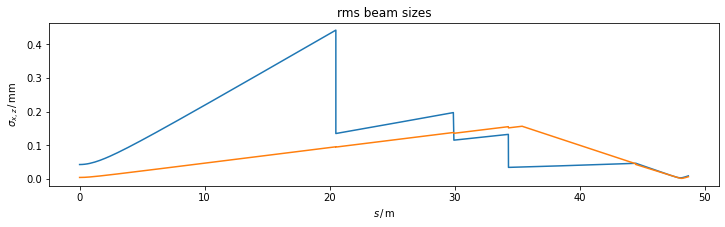

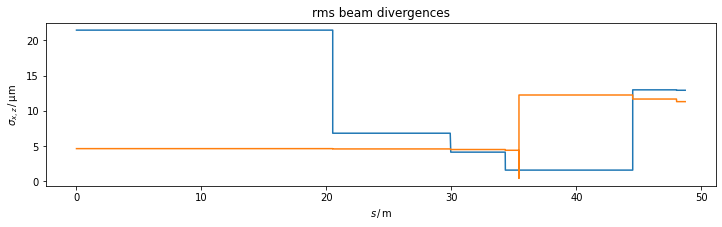

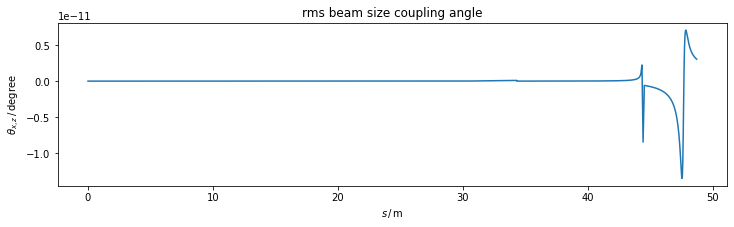

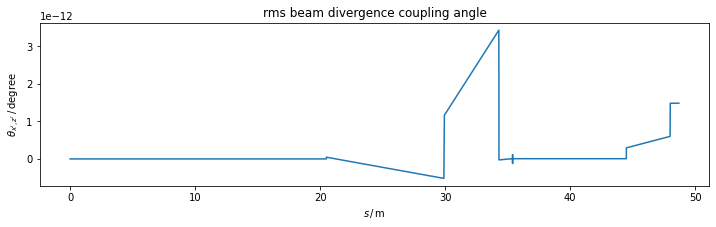

In [20]:
beam_stats = pkjson.load_any(pkio.py_path('beam_stats.json'))
degree = 180 / numpy.pi

x  = beam_stats.s

plt.figure(figsize=(12,3))
plt.title("rms beam sizes")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\sigma_{x,z}\,/\,\mathrm{mm}$')
plt.plot(x, numpy.array(beam_stats.sigmax) * 1e3, label=r'$\sigma_x$')
plt.plot(x, numpy.array(beam_stats.sigmaz) * 1e3, label=r'$\sigma_z$')
plt.show()

plt.figure(figsize=(12,3))
plt.title("rms beam divergences")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\sigma_{x,z}\,/\,\mathrm{\mu{m}}$')
plt.plot(x, numpy.array(beam_stats.sigdix) * 1e6, label=r'$\sigma_x$')
plt.plot(x, numpy.array(beam_stats.sigdiz) * 1e6, label=r'$\sigma_z$')
plt.show()

plt.figure(figsize=(12,3))
plt.title("rms beam size coupling angle")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\theta_{x,z}\,/\,\mathrm{degree}$')
plt.plot(x, numpy.array(beam_stats.angxz) * degree, label=r'$\theta_{x,z}$')
plt.show()

plt.figure(figsize=(12,3))
plt.title("rms beam divergence coupling angle")
plt.xlabel(r'$s\,/\,\mathrm{m}$')
plt.ylabel(r'$\theta_{x^\prime,z^\prime}\,/\,\mathrm{degree}$')
plt.plot(x, numpy.array(beam_stats.angxpzp) * degree, label=r'$\theta_{x\prime,z\prime}$')
plt.show()